# Overlapping Generations Heterogeneous Agents Model (OLGHA)

This notebook presents and solves a simple overlapping generations heterogeneous agents model. 
Households are subject to uninsurable idiosyncratic productivity shocks and a borrowing constraint.

The core of the code is adapted from routines developed in Auclert et al. (2019). "_Using the Sequence-Space Jacobian to Solve and Estimate Heterogeneous-Agent Models_": https://github.com/shade-econ/sequence-jacobian

A great resource is also the Econ-ARK project by Chris Carroll: https://github.com/econ-ark/HARK

# The Model

This simple model is inspired by the seminal work of Auerbach and Kotlikoff (1987) with a precise demographic structure and incomplete markets as in Huggett (1996).

## Demographic structure

Let $N_{i,t}$ denote the number of agents of age $i$ in period $t$. 
Total population is given by $N_t = \sum_i N_{i,t}$. 
Each period, $1+n$ households of age 0 are born. 
Subsequently, households face stochastic survival rates $\phi_{i-1,i}$ for $i\geq1$. 
These compound to $\Phi_{i}=\prod_{k=1}^{i}\phi_{k-1,k}$. 
By definition, at end of life, $\phi_{T,T+1}=0$.

Assuming there is one zero-year old at date $t=0$, the population of each age at time t is:

\begin{eqnarray}
N_{0,t} &=& \left(1+n\right)^{t},\\
N_{i,t}&=&\Phi_{i}\left(1+n\right)^{t-i}.
\end{eqnarray}

Total population $N_{t}$ is growing at the rate of entrants:

$$N_{t}=\sum_{i=0}^{T}N_{i,t}=\left(1+n\right)^{t}\sum_{i=0}^{T}\frac{\Phi_{i}}{\left(1+n\right)^{i}}.$$

We can write _population shares_ $\pi_{i}={N_{i,t}}/{N_{t}}$, then $\pi_{i}={\Phi_{i}}/{\left(1+n\right)^{i}}\pi_{0}$ where $\pi_{0}=\left(\sum_{i=0}^{T}{\Phi_{i}}/{\left(1+n\right)^{i}}\right)^{-1}$.

## Households

Households enter economic life and start working at age $T^{w}$, retire at age $T^{r}$, and die for sure at age $T$.
They maximize lifetime utility

$$ \sum_{i=T^{w}}^{T}\beta^{i}\Phi_{i}u\left(c_{i}\right), $$

where $\Phi_i$ is the probability of surviving up to age $i$. 
Agents are subject to the budget constraints

$$ c_i + a_{i+1} = \frac{1+r}{\phi_{i-1,i}} a_{i} + y_i. $$

Before retirement, households supply labor $\bar{h}_i$ inelastically and are subject to idiosyncratic productivity shocks $\varepsilon$. 
Once retired, households perceive social security benefits $d_t$. 
Income is then

$$y_{i,t} = \begin{cases} (1-\tau_t) w_t \bar{h}_i \varepsilon & i < T^{r} \\ d_t & i\ge T^{r} \end{cases}.$$

where $(1-\tau_t)w_t$ is the real wage net of the payroll tax used to finance the social security system. 
We will assume that $\varepsilon$ follows a Markov chain with transition probability matrix $\Pi$.

Households are also subject to a borrowing constraint

$$ a_{i+1} \ge \underline{a}.$$

## Production

A unit measure of firms produce output with effective labor $L_t = \sum_{i}N_{i,t}\bar{h}_{i}$ and capital $K_t$ with technology

$$ Y_t = F(K_t, L_t) = K_t^{\alpha} L_t^{1-\alpha}. $$

Perfect competition implies the following factor prices

\begin{eqnarray}
w_t &=& (1-\alpha) \left(\frac{K_t}{L_t}\right)^{\alpha},  \\
r_t &=& \alpha \left(\frac{K_t}{L_t}\right)^{\alpha-1} - \delta. \\
\end{eqnarray}

## Government

The government finances the social security benefits $d_t$ with a payroll tax $\tau_t$ such that

$$ \underbrace{\tau_t  \sum_{i=T^{w}}^{T^{r}-1} w_t N_{i,t}\bar{h}_{i}}_{\text{Taxes}} = \underbrace{\sum_{i=T^{r}}^{T} d_{t} N_{i,t}}_{\text{Transfers}} .$$

# Equilibrium

A stationary equilibrium is a collection of policy functions $c(a,\varepsilon,i)$ and  $a'(a,\varepsilon,i)$ such that, given initial distribution of asset holdings, demographic parameters $n$ and $(\Phi_i)_i$, a government's social security policy $\{\tau_t, d_t\}_t$, relative prices $\{r_t,w_t\}_t$:

* The population distribution is stationary and consistent with $n$ and $(\Phi_i)_i$,

* Individual and aggregate behaviors are consistent,

$$L_t=\sum_{i=0}^{T}N_{i,t}\bar{h}_{it}, \qquad A_t=\sum_{i=0}^{T}N_{i,t}a_{it}, \qquad C_t=\sum_{i=0}^{T}N_{i,t}c_{it},$$

* The policy functions $c(a,\varepsilon,i)$ and  $a'(a,\varepsilon,i)$ are consistent with the households' optimization problem,

* The relative prices $\{r_t,w_t\}_t$ are consistent with firms' optimization problem,

* The government's budget is balanced

$$ \tau_t  \sum_{i=T^{w}}^{T^{r}-1} w_t N_{i,t}\bar{h}_{i}= \sum_{i=T^{r}}^{T} d_{t} N_{i,t},$$

* The asset market clears

$$ A_t = K_t, $$

* The goods market clears

$$ Y_t = C_t + K_{t+1} - (1-\delta)K_t ,$$

# Computation

We solve the households' problem using the endogenous grid points method of Carroll (2006) to obtain the policy functions and Young (2010)'s non-stochastic simulation method to translate optimal policies between grid points to transition probabilities on the grid.

## 1. Computing policy functions: backward iterations

The household problem is given by

\begin{eqnarray}
V(\varepsilon,a,i)&=&\max_{c_i,a_{i+1}}\frac{c_i^{1-\sigma}}{1-\sigma}+{\beta}\phi_{i,i+1}\mathbb{E}[V(\varepsilon',a',i+1)|\varepsilon] \\
\text{s.t.} && c_i + a_{i+1} = \frac{1+r}{\phi_{i-1,i}} a_{i} + y_i \\
&& a_{i+1} \ge \underline{a}
\end{eqnarray}

The Euler equation of this problem is

$$ c_i^{-\sigma} \ge \beta(1+r)\mathbb{E}\left[c_{i+1}^{-\sigma}\right] $$

and holds with equality when the borrowing constraint does not bind.

We can solve this problem with Carroll (2006)'s method of endogenous grid points. 
We iterate backwards on the consumption policy function in the Euler equation above, starting from the last period of life. 

Let's define cash-on-hand as, for a given asset grid $a$

$$ z_{i}\left(a,\varepsilon\right) \equiv {y_{i}}(\varepsilon)+\frac{\left(1+r\right)}{\phi_{i-1,i}}a. $$

In the last period of life, i.e. $i=T$, agents simply consume their cash-on-hand

$$ c_T = z_T(a, \varepsilon), \qquad a_T = 0. $$

We can then solve by backward recursion

$$ {c}\left(i,\varepsilon,{a}\right)^{-\sigma}={\beta}(1+r)\mathbb{E}\left[c\left(i+1,\varepsilon',a'\left(i,\varepsilon,{a}\right)\right)^{-\sigma}|\varepsilon\right] ,$$

using the method of endogenous grids: starting from the consumption policy at $i+1$ and any grid point for tomorrow's assets $a'$, compute consumption $c$ from the above Euler equation, then compute assets $a$ from solving the budget constraint

$$ c +a' = z_{j}\left({a},\varepsilon\right). $$

This yields the inverse asset policy $a\left(a',\varepsilon,i\right)$, which can be inverted to get the asset policy $a'\left(a,\varepsilon,i\right)$.
If this yields $a'\left(a,\varepsilon,i\right)\le\underline{a}$ we replace the asset policy by $a'\left(a,\varepsilon,i\right)=\underline{a}$. 

## 2. Computing distributions: forward iterations

Given a distribution of agents $D(\varepsilon,a, i)$, we obtain $D(\varepsilon',a', i+1)$ following Young (2010) as 

$$D(\varepsilon',a', i+1) = \sum_\varepsilon D(\varepsilon,a'^{-1}\left(a,\varepsilon,i\right),i) \cdot \Pi(\varepsilon,\varepsilon'), $$

where $a'^{-1}\left(a,\varepsilon,i\right)$ is the inverse asset policy function and $\Pi$ is the Markov transition matrix over idiosyncratic productivity states.

First, we use the asset policy function to construct the distribution $D(\varepsilon,a',i)$:

* For $i=T^{w}$, we initialize this distribution with a mass point at $0$ since no agent holds any asset,

* Then, for each $(\varepsilon, a)$, we interpolate to find the $\lambda$ such that $ a'(\varepsilon, a, i) = \lambda a^1 + (1-\lambda)a^2$ where $a^1$ and $a^2$ are the closest grid points on both sides of $a'(\varepsilon, a, i)$,

* We then add $\lambda D(\varepsilon,a,i)$ to $D(\varepsilon,a^1,i)$ and $(1-\lambda) D(\varepsilon,a,i)$ to $D(\varepsilon,a^2,i)$ (think of it as a lottery).

Then, we use the Markov transition matrix $\Pi$ of $\varepsilon$ to go from $D(\varepsilon,a',i)$ to $D(\varepsilon',a',i+1)$.

## 3. Aggregation

We can obtain aggregate variables as

$$ A = \sum N_{i} \cdot a'\left(a,\varepsilon,i\right) \cdot D(\varepsilon,a, i), \qquad C = \sum N_{i} \cdot c\left(a,\varepsilon,i\right) \cdot D(\varepsilon,a, i) $$


# Steady State

Let's now solve for the steady-state of the model. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

from utils import set_parameters, make_path, pack_jacobians, ineq
from production import ss_production
from government import government
from household import household_ss_olg
from demographics import pop_stationary, trans_pop
from td import td_olg, get_Jacobian, td_GE_olg

First, we set the parameters of the model using `set_parameters()` and store them in a dictionary named `params`.
This functions defines the age structure, calculates the stationary population distribution, defines production and preferences parameters, constructs the asset grid, and discretizes the idiosyncratic productivity shocks.

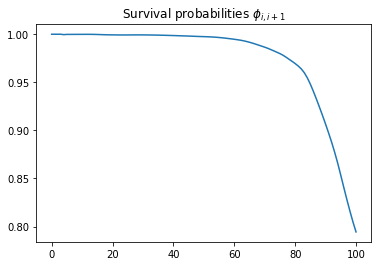

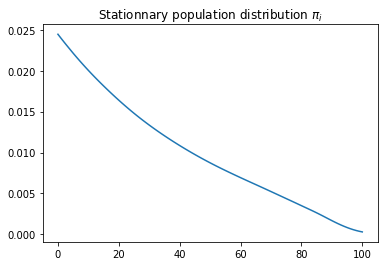

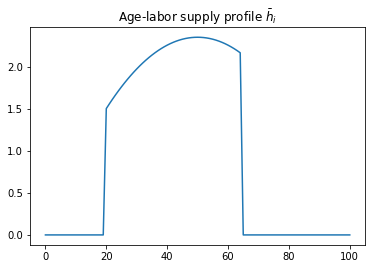

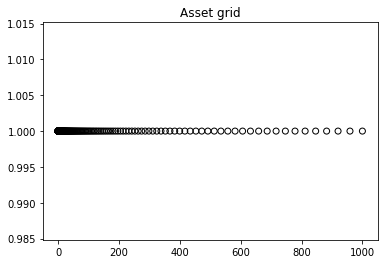

In [2]:
params = set_parameters()

plt.plot(params['phi'])
plt.title(r'Survival probabilities $\phi_{i,i+1}$')
plt.show()

plt.plot(params['pi'])
plt.title(r'Stationnary population distribution $\pi_i$')
plt.show()

plt.plot(params['h'])
plt.title(r'Age-labor supply profile $\bar{h}_i$')
plt.show()

plt.scatter(params['a'], np.ones_like(params['a']), facecolors='none', edgecolors='k')
plt.title('Asset grid')
plt.show()

Let's now compute the real wage and the capital-labor ratio implied by the parameters we just set.
Remember that given $r$, $\alpha$ and $\delta$, we can derive $K_t/L_t$ that determines $w_t$. 
From $K_t/L_t$ we can also obtain $K_t/N_t = K_t/L_t \cdot \sum_{j}\pi_{i,t}\bar{h}_{i}$.

In [3]:
w, K_L = ss_production(params['r'], params['alpha'], params['delta'])
K = K_L * params['workers']
print(f'Real wage: {w}')
print(f'K/L ratio: {K_L}')

Real wage: 1.1509986750018124
K/L ratio: 5.153725410455877


We can now choose the payroll tax rate and the social security benefits to clear the government's budget constraint.
We set $\tau=20\%$ and compute $d$ to balance the budget given the demographic structure:

$$ d_t = \tau_t w_t \frac{\sum_{i=T^{w}}^{T^{r}-1}\pi_{i,t}\bar{h}_{i}}{\sum_{i=T^{r}}^{T}  \pi_{i,t}} $$

In [4]:
tau, d = government(w, params['retirees'])
print(f'Payroll tax: {100*tau: .0f}%')
print(f'Benefits: {d: .2f}')

Payroll tax:  20%
Benefits:  2.09


We have now all the necessary inputs to solve the household's problem.
In equilibrium we want to have that asset supply equates asset demand, i.e. $A = K$. 
There are multiple ways to proceed.
Here we take as given a certain interest rate $r$ that implies a certain level of capital $K$.
We will then calibrate the subjective discount factor $\beta$ such that $A=K$. 
This allows us to choose the interest rate that clears the market.
Alternatively, we could fix $\beta$ and solve for the interest rate $r$.

In [5]:
def error(beta, K, params, w, tau, d):
    params['beta'] = beta
    return household_ss_olg(params, w, tau, d)['A'] - K

params['beta'] = opt.newton(error, x0=0.95, args=(K, params, w, tau, d))
print(f'Calibrated subjective discount factor : {params["beta"]: .2f}')

Calibrated subjective discount factor :  0.90


Let's now evaluate the equilibrium objects at this value of $\beta$ and visualize the equilibrium outcomes.

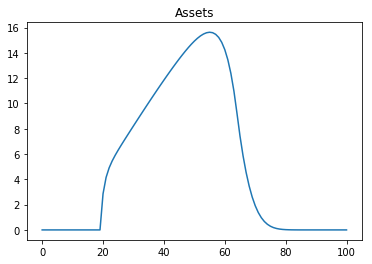

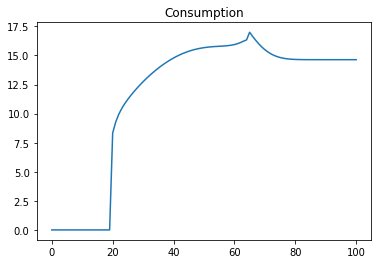

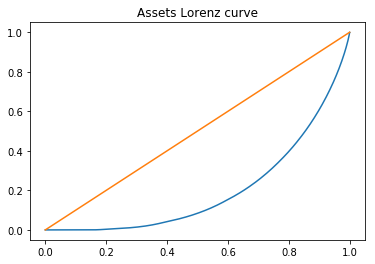

In [6]:
ss = household_ss_olg(params, w, tau, d)

plt.plot()
plt.title('Assets')
plt.plot(ss['A_j'])
plt.show()

plt.plot()
plt.title('Consumption')
plt.plot(ss['C_j'])
plt.show()

lorenz_a_pctl, lorenz_a = ineq(params, ss)

plt.plot()
plt.title('Assets Lorenz curve')
plt.plot(lorenz_a_pctl, lorenz_a)
plt.plot([0,1],[0,1])
plt.show()

# Transitional Dynamcis

## Partial equilibrium 

Suppose that the population growth rate suddenly drops from 2% to 1%. 
Given the demographic structure above, and for a fixed $\phi$, we can simulate exactly the evolution of the population from the time of the shock until it reaches the new stationary distribution.

Let's visualize how the stationary distribution is affected.

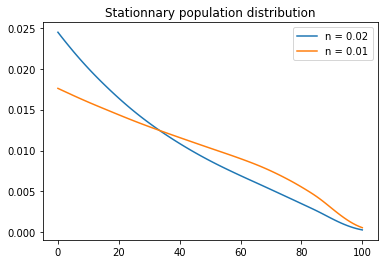

In [7]:
n_new = 0.01
pi_old = pop_stationary(params['n'], params['phi'], T=params['T'])
pi_new = pop_stationary(n_new, params['phi'], T=params['T'])

plt.plot(pi_old, label=f'n = {params["n"]}')
plt.plot(pi_new, label=f'n = {n_new}')
plt.legend()
plt.title('Stationnary population distribution')
plt.show()

Let's now simulation the evolution of the distribution for the first 100 years after the shock.

For later, we will need an additional $(T-T^{w})$ years to compute a full cross-section of agents in the 100 years of the transition.
Note that

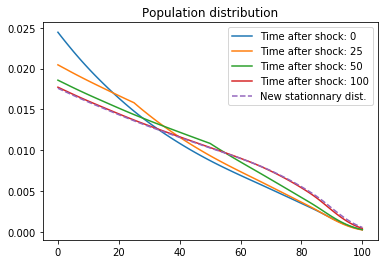

In [8]:
Ttrans = 100
Ttrans_full = Ttrans + params['T'] - params['Tw']
pi_trans = trans_pop(params['pi'], n_new, params['phi'], Ttrans=Ttrans_full)

for t in [0, 25, 50, 100]:
    plt.plot(pi_trans[t,:], label=f'Years after shock: {t}')
plt.plot(pi_new, label='New stationnary dist.', ls='--')
plt.legend()
plt.xlabel('Year')
plt.title('Population distribution')
plt.show()

Let's now compute the full transitional dynamics.
We first compute the partial equilibrium transition, that is, for a fixed interest rate $r_t = r_0, \forall t>0$.

We store the path of the interest rate and the initial steady-state distribution we obtained above. 
The path of the interest rate is stores as dict to make it easier to allow additional paths of inputs.

In [9]:
paths_trans = {'r':make_path(params['r'], Ttrans)}
D0 = ss['D']

Computing the transiton relies on the exact same procedure as to compute the steady-state: iterating backwards to get the policies, and forward to get the distributions.
We only need to be careful about the inputs into the household problem, e.g. $r_t$ varies with time, the government will need to adjust its budget in response to the demographic change, etc.

In [10]:
td_PE = td_olg(paths_trans, params, pi_trans, D0)

Let's visualize some outcomes along the transition.

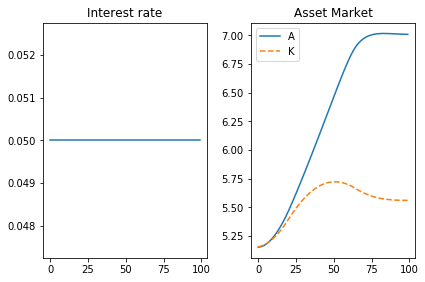

In [18]:
fig, a = plt.subplots(1, 2, squeeze=False)
a[0][0].plot(td_PE['r'])
a[0][0].set_title('Interest rate')
a[0][1].plot(td_PE['A'], label='A')
a[0][1].plot(td_PE['K'][:Ttrans], '--', label='K')
a[0][1].set_title('Asset Market')
a[0][1].legend()
fig.tight_layout(pad=1.0)
plt.show()

## General equilibrium 

Suppose now that you want to solve for the general equilibrium along the transition, i.e. find $\mathbf{r}\equiv\{r_t\}$ such that $A_t=K_t$ for all $t$.

One efficient method of solving for the path $\mathbf{r}$ is Newton's method:

1. Starting from $j=0$, guess a path for the interest rate $\mathbf{r}^{0}$
2. Calculate the path of error in the asset market clearing condition: $\mathbf{H}(\mathbf{r})\equiv \{ A_t(r_t)-K_t(r_t) \}_t$
3. Update the guess according to $ \mathbf{r}^{j+1} = \mathbf{r}^{j} - \mathbf{H}_{\mathbf{r}}^{-1} \cdot \mathbf{H}(\mathbf{r}^{j}) $ where $\mathbf{H}_{\mathbf{r}}$ is the Jacobian. 

We first need to compute the Jacobian $\mathbf{H}_{\mathbf{r}}$. 
Every column of this matrix corresponds to the change in the error in the asset market clearing condition in response to a change in the interest rate at a different horizon.
It can be computed directly using automatic differentiation.

In [12]:
inputs, outcomes = ['r'], ['nad']
J = get_Jacobian(paths_trans, params, pi_trans, D0, inputs, outcomes)

# Pack into one matrix
H_X = pack_jacobians(J, inputs, outcomes, Ttrans)

Let's visualize some columns of the Jacobian.

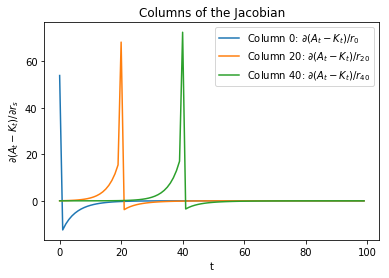

In [13]:
plt.plot()
columns = [0, 20, 40]
for c in columns:
    plt.plot(J['nad']['r'][:, c], label=f'Column {c}: $\partial(A_t-K_t)/r_{{{c}}}$')
plt.legend()
plt.xlabel('t')
plt.ylabel(f'$\partial(A_t-K_t)/\partial r_s$')
plt.title(f'Columns of the Jacobian')
plt.show()

We can now solve for the general equilibrium transition using Newton's method.

In [15]:
td_GE = td_GE_olg(H_X, paths_trans, params, pi_trans, D0, outcomes, inputs, xtol=1E-6, disp=True)

On iteration 0
   max error for nad is 1.45E+00
On iteration 1
   max error for nad is 1.56E-02
On iteration 2
   max error for nad is 2.34E-04
On iteration 3
   max error for nad is 2.26E-05
On iteration 4
   max error for nad is 3.08E-06
On iteration 5
   max error for nad is 4.85E-07


Let's visualize some objects along the transition.

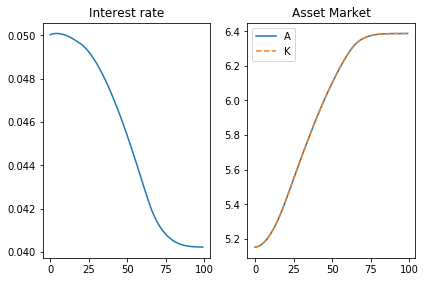

In [17]:
fig, a = plt.subplots(1, 2, squeeze=False)
a[0][0].plot(td_GE['r'])
a[0][0].set_title('Interest rate')
a[0][1].plot(td_GE['A'], label='A')
a[0][1].plot(td_GE['K'][:Ttrans], '--', label='K')
a[0][1].set_title('Asset Market')
a[0][1].legend()
fig.tight_layout(pad=1.0)
plt.show()